笔记：
    1.训练误差和泛化误差  训练数据集上的误差；任意一个测试集上的误差期望
    2.机器学习基本假设:样本独立同分布假设
    3.模型选择：验证数据集 k折交叉验证
    4.欠拟合：训练误差高，过拟合：训练误差远小于测试误差
       模型复杂度、训练数据集大小

In [2]:
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, gluon,nd
from mxnet.gluon import data as gdata, loss as gloss, nn


1.生成数据集

In [3]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = nd.random.normal(shape = (n_train + n_test, 1 ))

poly_features = nd.concat(features, nd.power(features,2),
nd.power(features,3))

labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
+ true_w[2] * poly_features[:, 2] + true_b)

labels += nd.random.normal(scale = 0.1, shape = labels.shape)

In [4]:
features[:2], poly_features[:2], labels[:2]

(
 [[2.2122064]
  [0.7740038]]
 <NDArray 2x1 @cpu(0)>,
 
 [[ 2.2122064   4.893857   10.826221  ]
  [ 0.7740038   0.5990819   0.46369165]]
 <NDArray 2x3 @cpu(0)>,
 
 [51.674885   6.3585763]
 <NDArray 2 @cpu(0)>)

In [13]:
#2定义、训练和测试模型
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals = None, y2_vals = None,legend = None, figsize = (3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals,y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle = ':')
        d2l.plt.legend(legend)

In [14]:
num_epochs, loss = 100, gloss.L2Loss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])
    train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features, train_labels), batch_size, shuffle = True)
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate' : 0.01})

    train_ls,test_ls = [],[]
    for _ in range(num_epochs):
        for X,y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(loss(net(train_features),
        train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features),
        test_labels).mean().asscalar())
    print('final  epoch: train loss', train_ls[-1],'test loss',test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
    range(1,num_epochs + 1), test_ls, ['train', 'test'])
    print('weight', net[0].weight.data().asnumpy(),
    '\nbias:', net[0].bias.data().asnumpy())

final  epoch: train loss 0.0072701857 test loss 0.012189402
weight [[ 1.3314905 -3.3619175  5.561026 ]] 
bias: [4.950404]


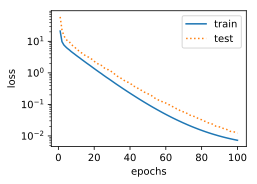

In [15]:
#三阶多项式函数拟合（正常）
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :],
labels[:n_train], labels[n_train:])

final  epoch: train loss 43.99766 test loss 160.85468
weight [[15.548501]] 
bias: [2.287274]


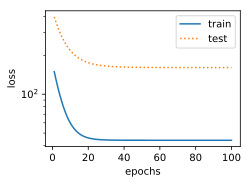

In [16]:
#线性函数拟合（⽋拟合）
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train],
labels[n_train:])

final  epoch: train loss 0.41342217 test loss 104.28466
weight [[1.3431138 1.9589288 3.5076284]] 
bias: [1.2364585]


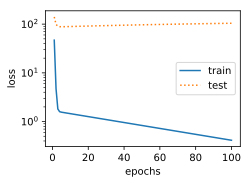

In [17]:
#训练量不⾜（过拟合）
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2],
labels[n_train:])